In [1]:
import sys
sys.path.append('/home/sdybing/neic-mlaapde')

from mlaapde.access import MLAAPDE_Access
from mlaapde import UTC
import matplotlib.pyplot as plt
import numpy as np
import os.path
import os
import shutil

# Uses second GPU - use this if the first is busy
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

#mlpa = MLAAPDE_Access(data_dir='/data/hank/mlaapde_subset/data', random_seed=616) # 3 months
mlpa = MLAAPDE_Access(data_dir='/data/hank/mlaapde_v1b/data', random_seed=616) # 3 months
dataset = 'v1b'

#!cat mlaapde/mlaapde.ini # checking the config file to make sure it points at the data

mlpa.data_dir # checks to make sure it's looking at the data right

#mlpa.default_args # includes the default labelsmlpa.available_labels()

#mlpa.available_labels()

2022-07-12 10:26:16 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.__init__() starting
2022-07-12 10:26:29 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.__init__() complete


'/data/hank/mlaapde_v1b/data'

In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from keras import backend as K

In [3]:
# Values from .ini file or chosen kwargs

nsamp = 1000
sr = 40
trim_sec = 60
trim_pre_sec = trim_sec
trim_post_sec = trim_pre_sec
sample_len = trim_pre_sec + trim_post_sec
train_split = 0.8
valid_split = 0.2

save_dir = '/home/sdybing/neic-mlaapde/tterror_std/' + str(dataset) + '_' + str(nsamp) + 'samp_' + str(trim_sec*2) + 'sec_window'
if os.path.isdir(save_dir):
    pass
else: # deletes directory to start over: shutil.rmtree(save_dir)  
    os.makedirs(save_dir)

# Pick extra labels and set keyword arguments for data parameters

return_labels = ['source_magnitude', 'source_magnitude_type']

kwargs = {'nsamp':nsamp, 'split':[train_split, valid_split], 'labels':return_labels, 'trim_pre_sec':trim_pre_sec, 'trim_post_sec':trim_post_sec}

In [4]:
waves, labels = mlpa.get_data(**kwargs)

train_waves = waves['training']
valid_waves = waves['validation']
# test_waves = waves['testing']

train_labels = labels['training']
valid_labels = labels['validation']
# test_labels = labels['testing']

train_waves_t = train_waves.transpose(0,2,1)
valid_waves_t = valid_waves.transpose(0,2,1)
train_mags = train_labels['source_magnitude']
valid_mags = valid_labels['source_magnitude']

2022-07-12 10:26:31 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.get_data() starting
2022-07-12 10:26:31 - mlaapde.access.MLAAPDE_Access - INFO - MLAAPDE_Access.sample_catalog() starting


KeyboardInterrupt: 

In [ ]:
### ----- Shifting the pick location so it's not always centered ----- ###

new_len = sample_len-3

# Shift training data

train_size = int(train_split*nsamp)

# Get some random time offsets
time_offset = np.random.uniform(low = 0, high = 3, size = train_size)

# Initialize arrays to hold shifted data and targets
shift_train_waves_t = np.zeros((train_size, int(new_len*sr), 3))

# This loop shifts data and targets and stores results
for ii, offset in enumerate(time_offset):

    # New timespan of data
    bin_offset = int(offset*sr)

    start_bin = bin_offset # Start of new shifted data
    end_bin = int(start_bin+new_len*sr) # New ending sample

    # Grabbing out the new batch of data using the shifted timespans
    shift_train_waves_t[ii, :, 0] = train_waves_t[ii, start_bin:end_bin, 0]
    shift_train_waves_t[ii, :, 1] = train_waves_t[ii, start_bin:end_bin, 1]
    shift_train_waves_t[ii, :, 2] = train_waves_t[ii, start_bin:end_bin, 2]

print(shift_train_waves_t.shape)

################################

# Shift validation data

valid_size = int(valid_split*nsamp)

time_offset = np.random.uniform(low = 0, high = 3, size = valid_size)

shift_valid_waves_t = np.zeros((valid_size, int(new_len*sr), 3)) 

for ii, offset in enumerate(time_offset):

    bin_offset = int(offset*sr)
    start_bin = bin_offset 
    end_bin = int(start_bin+new_len*sr)

    shift_valid_waves_t[ii, :, 0] = valid_waves_t[ii, start_bin:end_bin, 0] 
    shift_valid_waves_t[ii, :, 1] = valid_waves_t[ii, start_bin:end_bin, 1]
    shift_valid_waves_t[ii, :, 2] = valid_waves_t[ii, start_bin:end_bin, 2]

print(shift_valid_waves_t.shape)

In [ ]:
# MagNet model

epochs_number = 200
batch_size = 256 # originally 256
monte_carlo_sampling = 50
drop_rate = 0.5
filters = [32, 64, 96, 128, 256] 

inp1 = tf.keras.layers.Input(shape=(shift_train_waves_t.shape[1], shift_train_waves_t.shape[2]), name='input_layer') 

e = tf.keras.layers.Conv1D(filters[1], 3, padding = 'same')(inp1) 
e = tf.keras.layers.Dropout(drop_rate)(e, training=True)
e = tf.keras.layers.MaxPooling1D(4, padding='same')(e)

e = tf.keras.layers.Conv1D(filters[0], 3, padding = 'same')(e) 
e = tf.keras.layers.Dropout(drop_rate)(e, training=True)
e = tf.keras.layers.MaxPooling1D(4, padding='same')(e)

e = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, return_sequences=False, dropout=0.0, recurrent_dropout=0.0))(e)

e = tf.keras.layers.Dense(2)(e)
o = tf.keras.layers.Activation('linear', name='output_layer')(e)

model = tf.keras.models.Model(inputs=[inp1], outputs=o)

model.summary();

In [ ]:
class KerasDropoutPrediction(object):
    def __init__(self, model):
        self.model = model

    def predict(self, x, n_iter=10):
        predM = []
        auM = []

        for itr in range(n_iter):
            
            if itr == 0:
                print('Making predictions...')
            r = model.predict(x, batch_size=batch_size, verbose=0)

            pred = r[:, 0] 
            au = r[:, 1] 
            predM.append(pred.T)
            auM.append(au.T)

        predM = np.array(predM).reshape(n_iter,len(predM[0]))
        auM = np.array(auM).reshape(n_iter, len(auM[0])) 

        yhat_mean = predM.mean(axis=0)
        yhat_squared_mean = np.square(predM).mean(axis=0)

        sigma_squared = 10**(auM) 
        sigma_squared_mean = sigma_squared.mean(axis=0)

        ep_unc = predM.std(axis=0)  

        combined = yhat_squared_mean - np.square(yhat_mean)+ sigma_squared_mean

        return yhat_mean, sigma_squared_mean, ep_unc, combined

In [ ]:
training_samps = 100000
trim_secs = [2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 12.5, 15, 17.5, 20, 25, 30, 35, 40, 45, 50, 55, 60]
test_trim_secs = [2, 2.5, 60]
model_folder_path = '/home/sdybing/neic-mlaapde/timetrials/'
shift_status = 'shifted'

In [ ]:
import glob
import os

mean_errors = []
std_errors = []

for trim_sec in trim_secs:
    
    print('--------------------------')
    
    model_path = model_folder_path + shift_status + '/' + str(dataset) + '_' + str(training_samps) + 'samp_' + str(trim_sec) + 'sec/'
    #print(model_path)
    list_of_models = glob.glob(model_path + '*.h5') # * means all if need specific format then *.csv
    #print(list_of_models)
    latest_model = max(list_of_models, key=os.path.getctime)
    #print(latest_model)
    
    model.load_weights(latest_model)
    
    model_tag = latest_model[-12:-3]
    print('Model: ' + str(model_tag))
    
    kdp = KerasDropoutPrediction(model)
    predict, al_unc, ep_unc, comb = kdp.predict(shift_valid_waves_t, monte_carlo_sampling)
    
    fig4, ax = plt.subplots()
    ax.set_title(model_tag)
    ax.scatter(valid_mags, predict, alpha = 0.4, facecolors='none', edgecolors='r')
    ax.plot([valid_mags.min(), valid_mags.max()], [valid_mags.min(), valid_mags.max()], 'k--', alpha=0.4, lw=2)
    ax.set_xlabel('Measured magnitude')
    ax.set_ylabel('Predicted magnitude')
    #plt.show()
    #fig4.savefig(save_dir + '/pred_vs_meas_mag_' + model_tag + '.png');
    
    measured_mags = valid_mags
    predicted_mags = predict

    errors = []

    for idx in range(len(predicted_mags)):

        predicted = predicted_mags[idx]
        #print(prediction)
        measured = measured_mags[idx]

        error = predicted - measured
        errors.append(error)

    mean_error = np.mean(np.array(errors))
    std_error = np.std(np.array(errors))

    print('Mean error: ' + str(mean_error))
    print('Error standard deviation: ' + str(std_error))
    
    mean_errors.append(mean_error)
    std_errors.append(std_error)

In [69]:
win_lengths = []

for trim_sec in trim_secs:
    
    window_length = (trim_sec*2) - 3
    #print(trim_sec)
    #print(window_length)
    
    win_lengths.append(window_length)

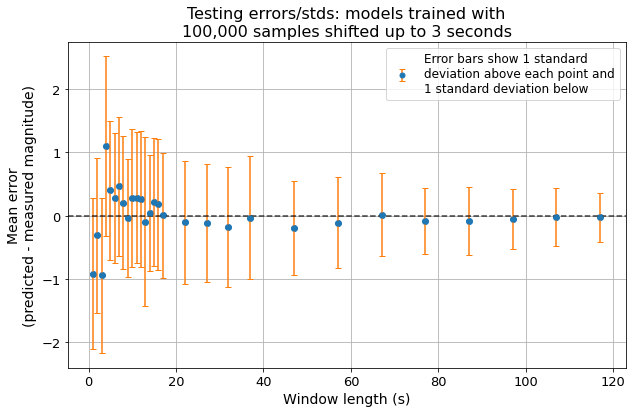

In [126]:
plt.figure(figsize = (10, 6))
plt.title('Testing errors/stds: models trained with\n100,000 samples shifted up to 3 seconds', fontsize = 16)
plt.errorbar(win_lengths, mean_errors, yerr = std_errors, fmt = '.', markersize = 10, ecolor = 'C1', capsize = 3, label = 'Error bars show 1 standard\ndeviation above each point and\n1 standard deviation below')
plt.scatter(win_lengths, mean_errors, color = 'C0')
plt.grid()
plt.xlabel('Window length (s)', fontsize = 14)
plt.ylabel('Mean error\n(predicted - measured magnitude)', fontsize = 14)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.legend(fontsize = 12)
plt.axhline(0, color = 'black', linestyle = '--', alpha = 0.75);

In [165]:
# Calculating the Mw where 1/2 the window length matches the length of the STF
# Houston paper method?

# window_len = 20 # seconds

# M0_Nm = (window_len/2)**(1/0.35) # Relationship is duration = M0 ^ 0.35 (M0 is 10^19 Nm)
# print(M0_Nm) # 719.69 * 10^17 = 7.19 * 10^19?

# M0_dyncm = M0_Nm * 10**19 * 10**7 # Converting to dyne-cm (mult by 10^17 * 10^7? Doesn't make sense)

# Mw = ((2/3)*np.log10(M0_dyncm)) - 10.73
# print(Mw)

# Mw2 = (np.log10(M0_Nm*10**19) - 9.1)/1.5
# print(Mw2)

# Why is this lower than it should be...?

719.6856730011522
8.508095238095237
8.504761904761905


In [184]:
# Singh et al. method? Halfway between 0.25 and 1 is 0.625

window_len = 600 # seconds

Tt = window_len / 2

M0_dyncm = Tt**3 * (0.625 * 10**23)

Mw = ((2/3)*np.log10(M0_dyncm)) - 10.73 # M0 in dyne-cm

print('Rupture duration: ' + str(int(Tt)) + ' seconds')
print('M0: ' + str(M0_dyncm) + ' dyne-cm')
print('Mw: ' + str(round(Mw,2)))

Rupture duration: 300 seconds
M0: 1.6875e+30 dyne-cm
Mw: 9.42


In [20]:
print(min(valid_mags))
print(max(valid_mags))

bins = np.arange(11,85,1)/10

data_bins = []

for abin in bins:

    i = np.where(valid_mags == abin)[0]
    predict_bin = np.array(predict[i])

    data_bins.append(predict_bin)

1.8
7.9


/tmp/ipykernel_7452/3511982267.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8], fontsize = 14)


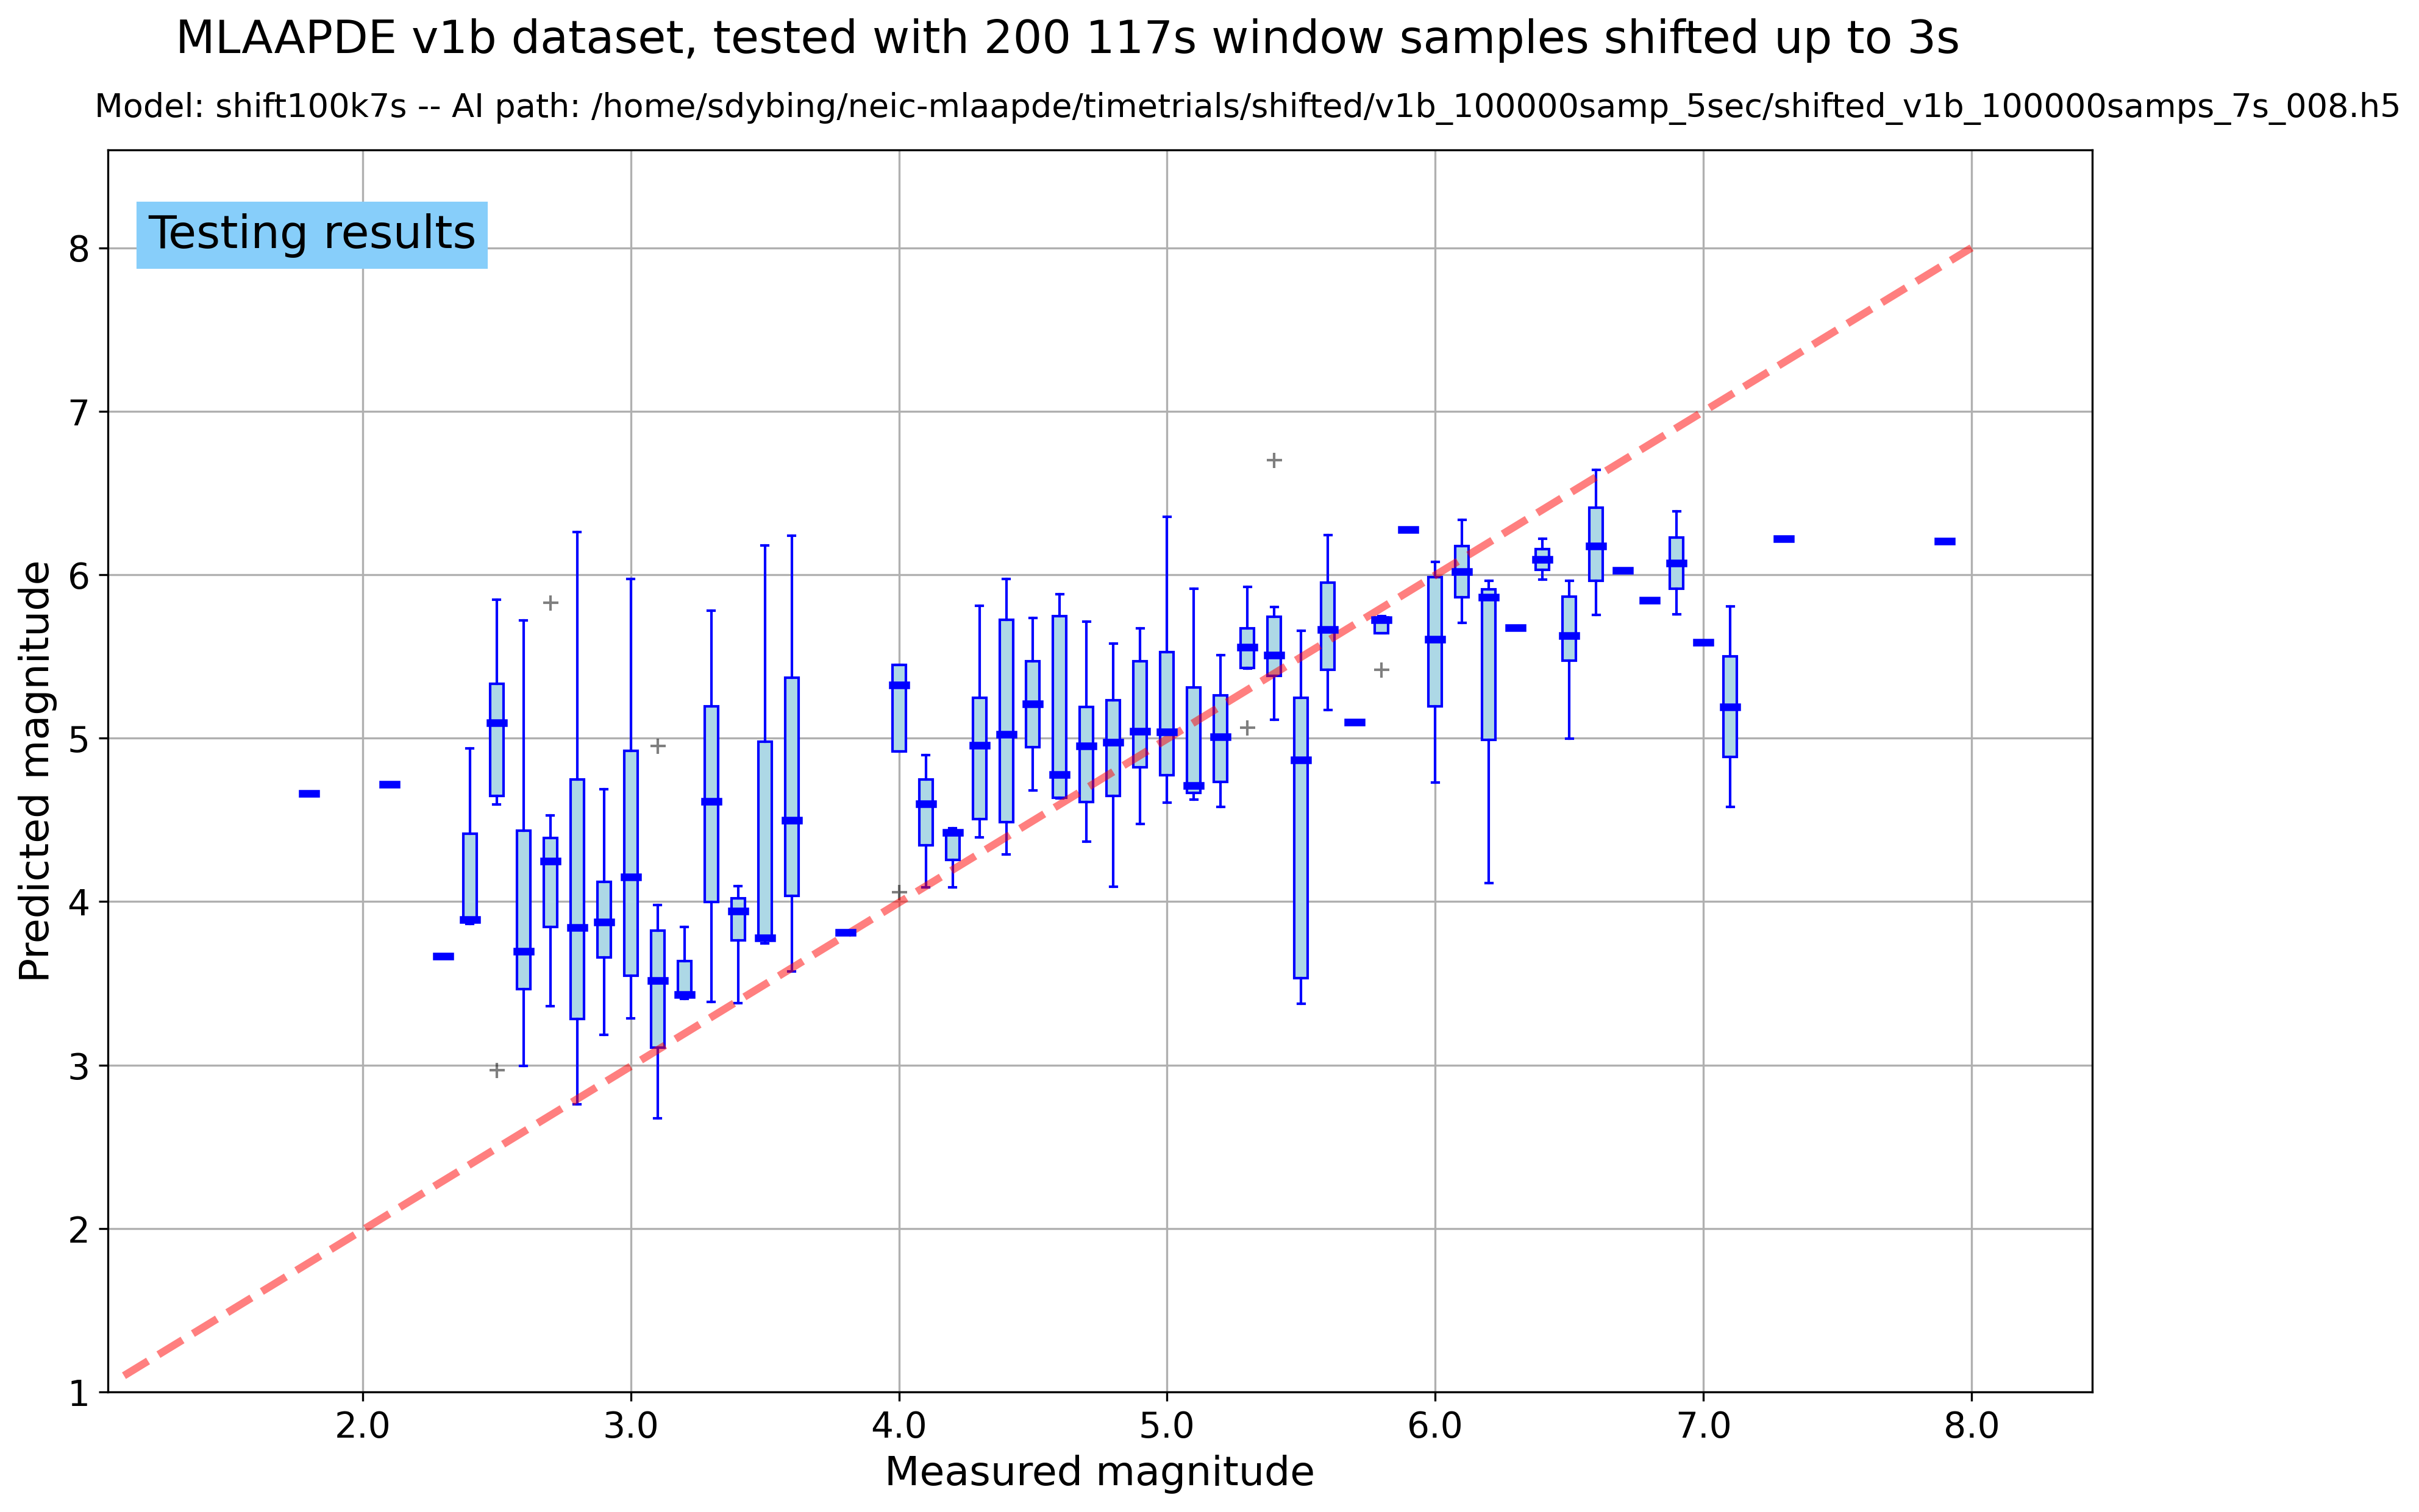

In [21]:
#fig = plt.figure(figsize =(14, 14), dpi = 300)
fig = plt.figure(figsize =(14, 9), dpi = 300)
fig.suptitle('MLAAPDE ' + str(dataset) + ' dataset, tested with ' + str(int(valid_split*nsamp)) + ' ' + str(new_len) + 's window samples shifted up to 3s', fontsize = 18, y = 0.96)
#ax = fig.add_subplot(211)

ax = fig.add_subplot(111)

# MODIFY BASED ON THE MODEL LOADED!!!
ax.text(x = 0, y = 8.8, s = 'Model: ' + model_tag + ' -- AI path: ' + latest_model, fontsize = 13)

ax.grid(which = 'major', axis = 'y')
ax.grid(which = 'major', axis = 'x', markevery = [10,20,30,40,50])
ax.set_ylim(1,8.6)

bp = ax.boxplot(data_bins, notch = False, patch_artist = True)

for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('blue')

for median in bp['medians']:
    median.set(color ='blue', linewidth = 3)

for whisker in bp['whiskers']:
    whisker.set(color ='blue', linewidth = 1)

for cap in bp['caps']:
    cap.set(color ='blue', linewidth = 1)

for flier in bp['fliers']:
    flier.set(marker ='+', color ='blue', alpha = 0.5)

bins_list = bins.tolist()

ax.set_xticklabels(bins_list, fontsize = 14)
#ax.set_xlabel('Measured magnitude', fontsize = 14)
ax.set_yticklabels([1, 2, 3, 4, 5, 6, 7, 8], fontsize = 14)
ax.set_ylabel('Predicted magnitude', fontsize = 16)
ax.set_xlabel('Measured magnitude', fontsize = 16)

ax.xaxis.set_major_locator(plt.MaxNLocator(8))

ax.plot((1.1,70),(1.1,8),'r--', linewidth = 3, alpha = 0.5)
ax.text(s = 'Testing results', x = 2, y = 8, fontsize = 18, backgroundcolor = 'lightskyblue');

#plt.savefig(save_dir + '/boxplot_' + model_tag + '.png', format = 'PNG', facecolor = 'white', transparent = False);

In [22]:
measured_mags = valid_mags
predicted_mags = predict

In [23]:
errors = []

for idx in range(len(predicted_mags)):
    
    predicted = predicted_mags[idx]
    #print(prediction)
    measured = measured_mags[idx]
    
    error = predicted - measured
    errors.append(error)

In [24]:
mean_error = np.mean(np.array(errors))
std_error = np.std(np.array(errors))

print(mean_error)
print(std_error)

0.4661054458618164
1.0965007905574826


Text(-0.05, 0.48, 'Mean: 0.47\nSTD: 1.1')

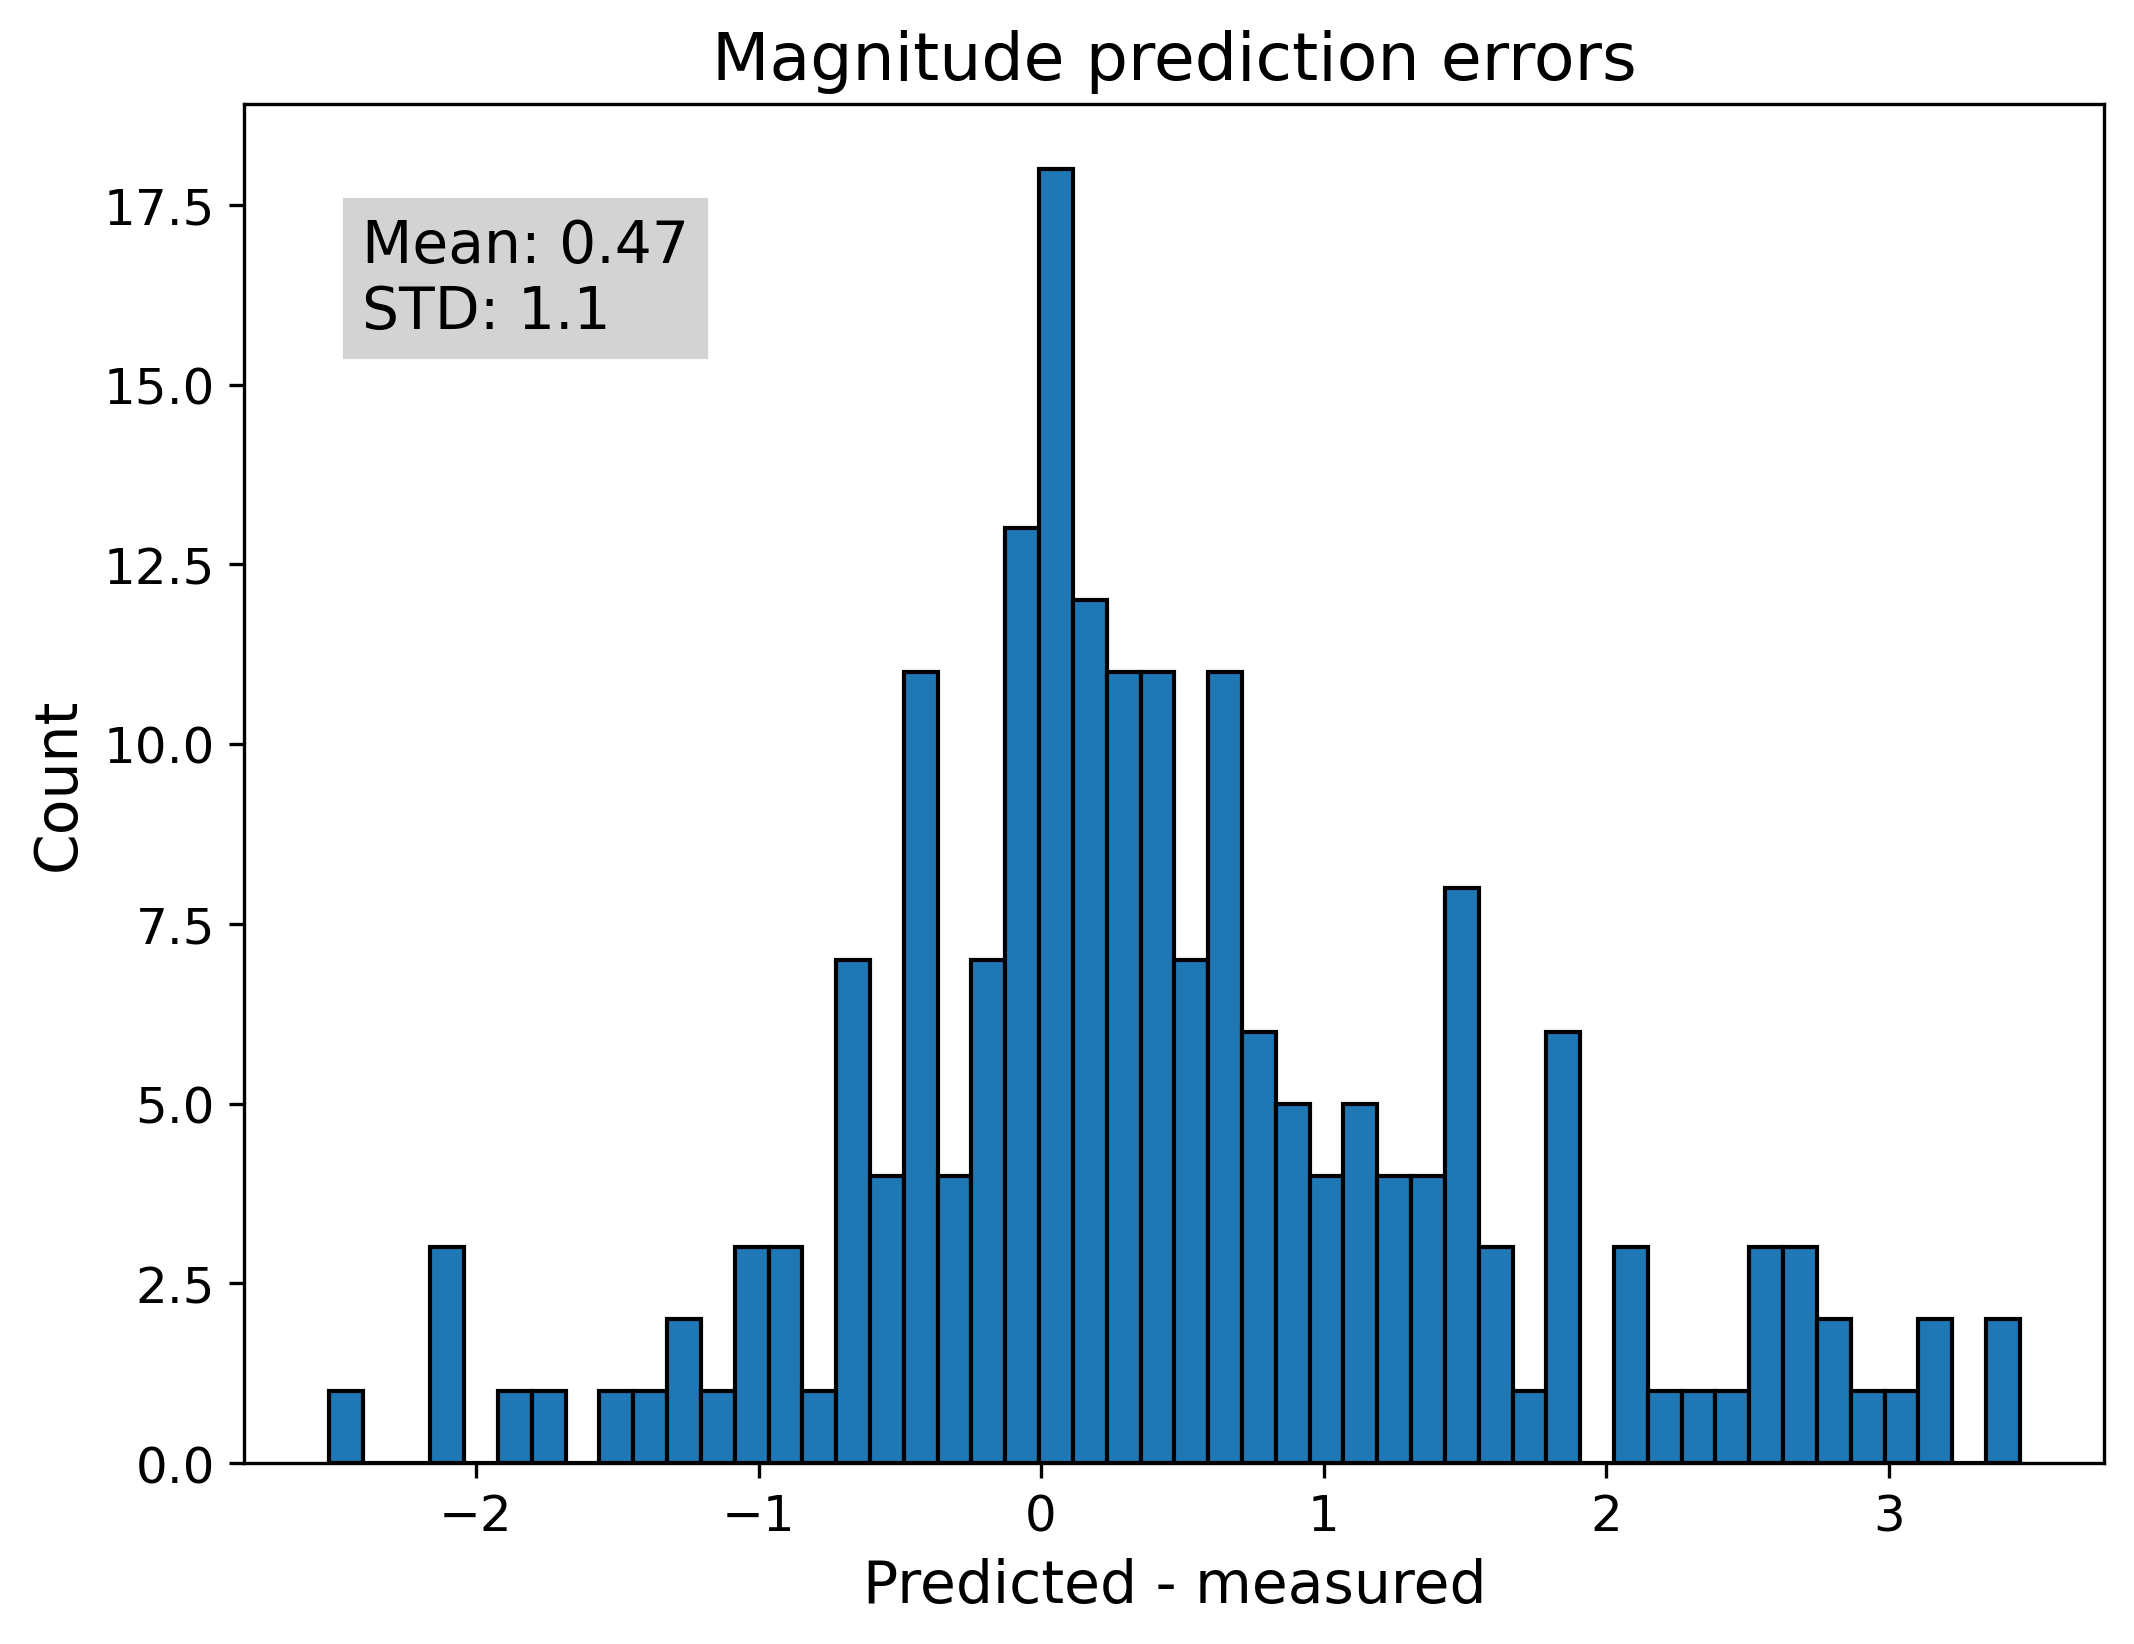

In [25]:
plt.figure(figsize =(8,6), dpi = 300)

plt.hist(errors, bins = 50, edgecolor='black')
plt.title('Magnitude prediction errors', fontsize = 16)
plt.xlabel('Predicted - measured', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.text(x = -0.05, y = 0.48, s = 'Mean: ' + str(round(mean_error,2)) + '\nSTD: ' + str(round(std_error,2)), fontsize = 14, backgroundcolor = 'lightgray', transform=ax.transAxes)

#plt.savefig(save_dir + '/error_histogram_' + model_tag + '.png', format = 'PNG', facecolor = 'white', transparent = False);